Group Members:

- Oumouhani El Vilaly
- Fredo Alejos Arrieta

In [1]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [2]:
from river import datasets

In [3]:
from river import datasets
from river import evaluate
from river import linear_model
from river import metrics
from river import optim
from river import preprocessing
from sklearn import pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle
import time
import numpy as np
from river import tree


### MANI START HERE

Etude 1

In [4]:
dataset_card = datasets.CreditCard()
dataset_card
!wget https://maxhalford.github.io/files/datasets/creditcardfraud.zip -O creditcardfraud.zip
!unzip -o creditcardfraud.zip

--2025-10-25 20:32:40--  https://maxhalford.github.io/files/datasets/creditcardfraud.zip
Resolving maxhalford.github.io (maxhalford.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to maxhalford.github.io (maxhalford.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/x-zip-compressed]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M   373MB/s    in 0.2s    

2025-10-25 20:32:42 (373 MB/s) - ‘creditcardfraud.zip’ saved [69155672/69155672]

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [5]:
import time
from river import metrics

def evaluate_river_model_stream(model, dataset_stream, n_samples=None):
      metrics_list = [metrics.ROCAUC(), metrics.Precision(), metrics.Recall(), metrics.F1()]
      """
      Incrementally train a River model on a streaming dataset and track metrics & runtime.

      Args:
          model: River model (e.g., LogisticRegression, LinearRegression)
          dataset_stream: iterable of (x, y) pairs, e.g., River dataset
          metrics_list: list of River metric objects (e.g., [metrics.ROCAUC(), metrics.Precision()])
          n_samples: optional, number of samples to evaluate (None = all)

      Returns:
          results: dict with metric name -> list of values over time
          runtimes: list of elapsed time per sample
      """
      results = {type(m).__name__: [] for m in metrics_list}
      runtimes = []

      # Convert test set to dict format for River

      for i, (x, y) in enumerate(dataset_stream):
          if n_samples is not None and i >= n_samples:
              break

          tic = time.time()
          # Prediction for metrics
          y_pred_proba = model.predict_proba_one(x).get(1, 0)
          elapsed = time.time() - tic
          runtimes.append(elapsed)

          # Update metrics
          for m in metrics_list:
              # For probabilistic metrics like ROCAUC, use probability
              if isinstance(m, metrics.ROCAUC) or isinstance(m, metrics.LogLoss):
                  m.update(y_true=y, y_pred=y_pred_proba)
              else:
                  # For threshold-based metrics, binarize at 0.5
                  m.update(y_true=y, y_pred=int(y_pred_proba > 0.5))
              results[type(m).__name__].append(m.get())

          # Train model incrementally
          model.learn_one(x, y)

      return results, runtimes



In [6]:
from river import naive_bayes

Uncompressing into /root/river_data/CreditCard


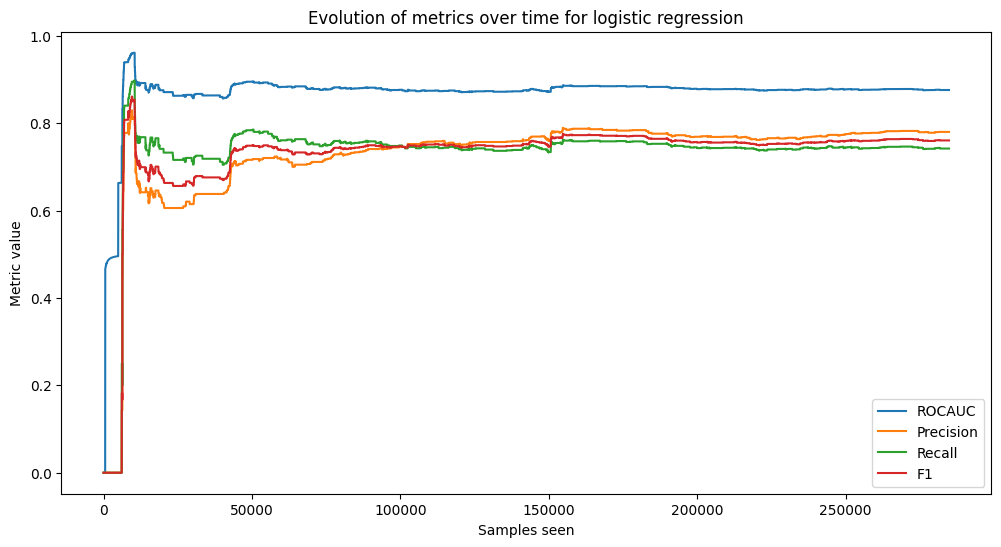

Average time per sample: 2.1160541896556677e-05


In [7]:

model = preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))



# Appel de la fonction
results, runtimes = evaluate_river_model_stream(model,dataset_card)

# Visualiser évolution des metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric_name, values in results.items():
    plt.plot(values, label=metric_name)
plt.xlabel("Samples seen")
plt.ylabel("Metric value")
plt.title("Evolution of metrics over time for logistic regression")
plt.legend()
plt.show()

# Temps moyen par échantillon
print("Average time per sample:", sum(runtimes)/len(runtimes))


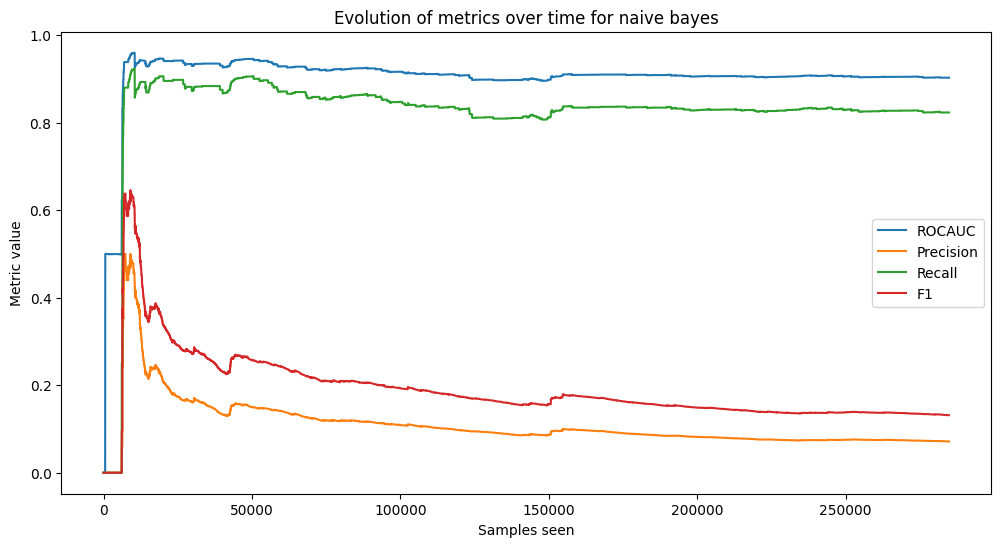

Average time per sample: 0.00023473430062519673


In [8]:
model=naive_bayes.GaussianNB()
#model = preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))

# Liste de metrics
#metrics_list = [metrics.ROCAUC(), metrics.Precision(), metrics.Recall(), metrics.F1()]

# Appel de la fonction
results, runtimes = evaluate_river_model_stream(model,dataset_card)


# Visualiser évolution des metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric_name, values in results.items():
    plt.plot(values, label=metric_name)
plt.xlabel("Samples seen")
plt.ylabel("Metric value")
plt.title("Evolution of metrics over time for naive bayes")
plt.legend()
plt.show()

# Temps moyen par échantillon
print("Average time per sample:", sum(runtimes)/len(runtimes))


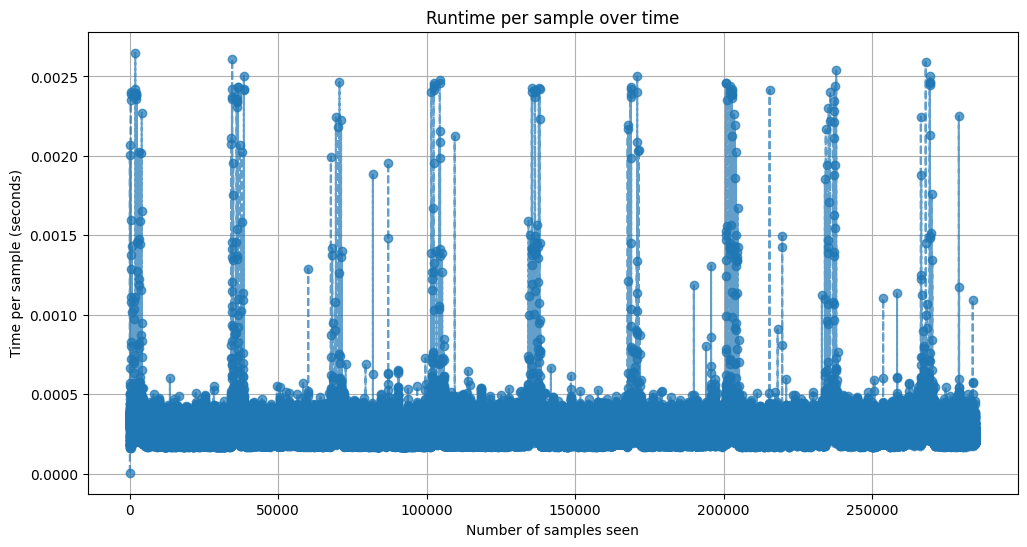

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(runtimes)+1), runtimes, marker='o', linestyle='dashed', alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Time per sample (seconds)")
plt.title("Runtime per sample over time")
plt.grid(True)
plt.show()

Tree methods

In [10]:
tree_h = tree.HoeffdingTreeClassifier(
    grace_period=50,          # 50 est trop petit, risque de splits prématurés
     # Multi-way splits (plus flexible)
    merit_preprune=True,       # Évite l'overfitting
)

In [11]:
tree_adaptive = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=50,           # Bon équilibre
    max_depth=None,             # Flexibilité pour capturer la classe minoritaire
    leaf_prediction='nba',      # 👍 Excellent pour l'unbalanced
    nb_threshold=0,             # Active Naive Bayes dès le début
    delta=1e-07,                # Confiance élevée
    drift_window_threshold=300, # Détection de drift
    bootstrap_sampling=True,    # Aide avec l'unbalanced
    merit_preprune=True,        # Évite l'overfitting
    seed=42
)

In [12]:
metrics_list = [metrics.ROCAUC(), metrics.Accuracy(), metrics.Recall(), metrics.F1()]

In [13]:
results_tree_h, runtimes_tree_h = evaluate_river_model_stream(tree_h, dataset_card)

In [14]:
results_tree_adaptive, runtimes_tree_adaptive= evaluate_river_model_stream(tree_adaptive,dataset_card)

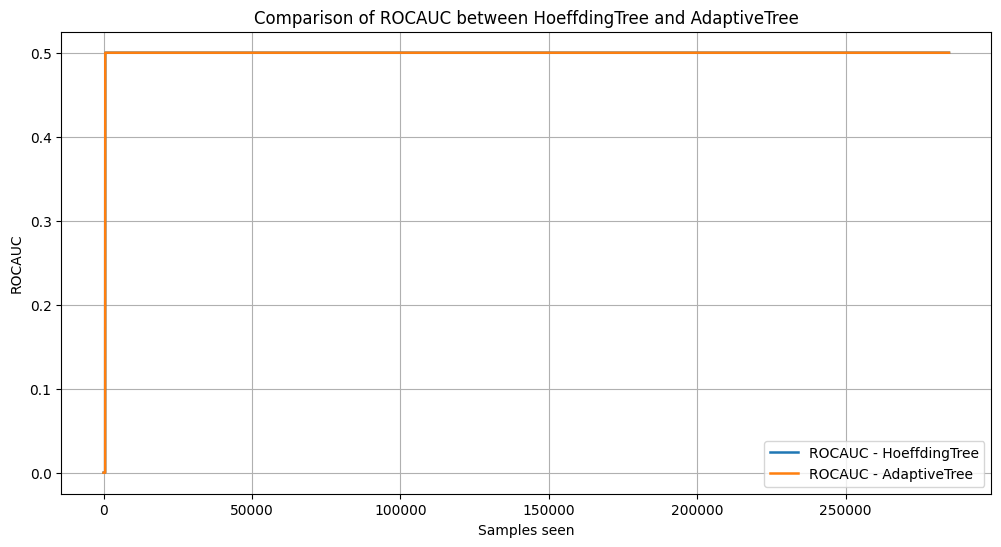

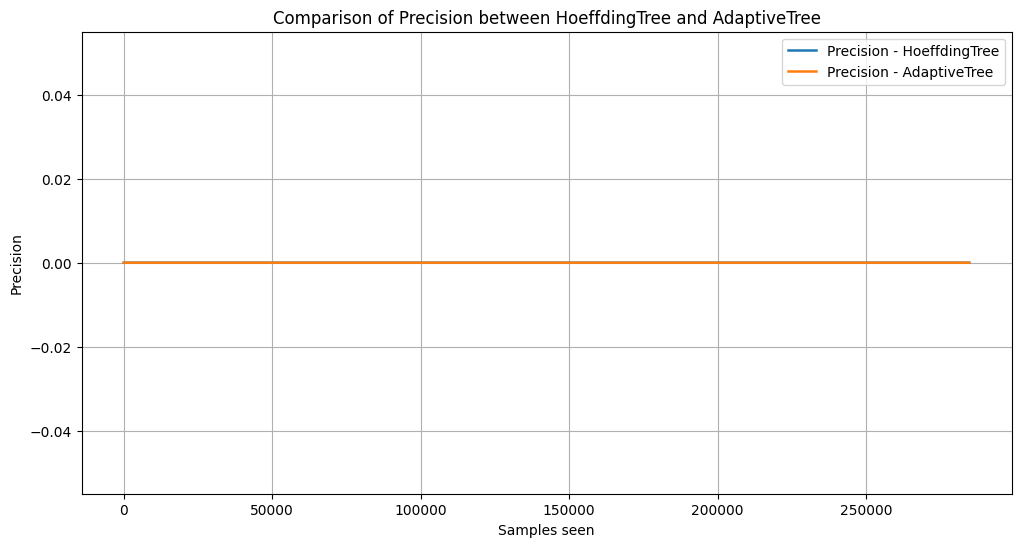

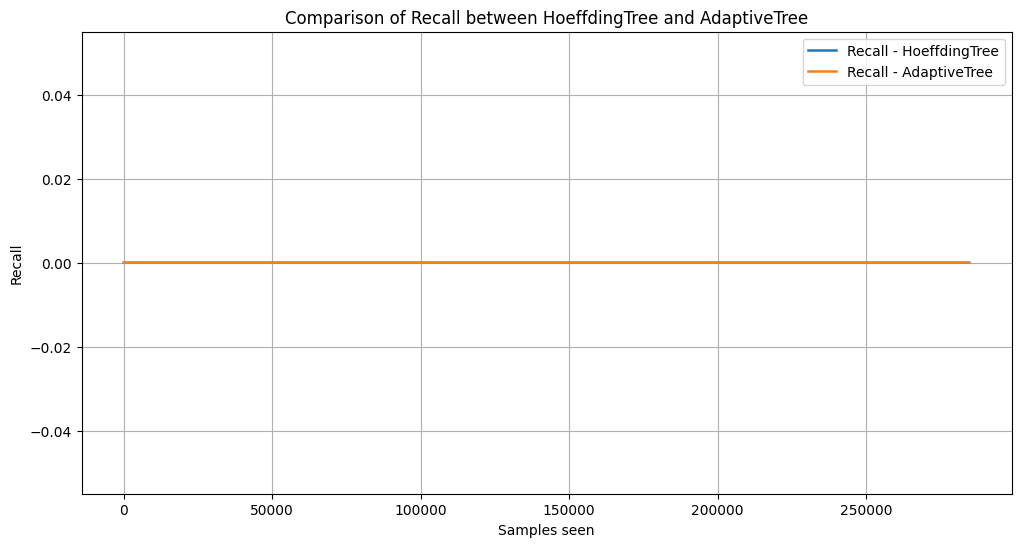

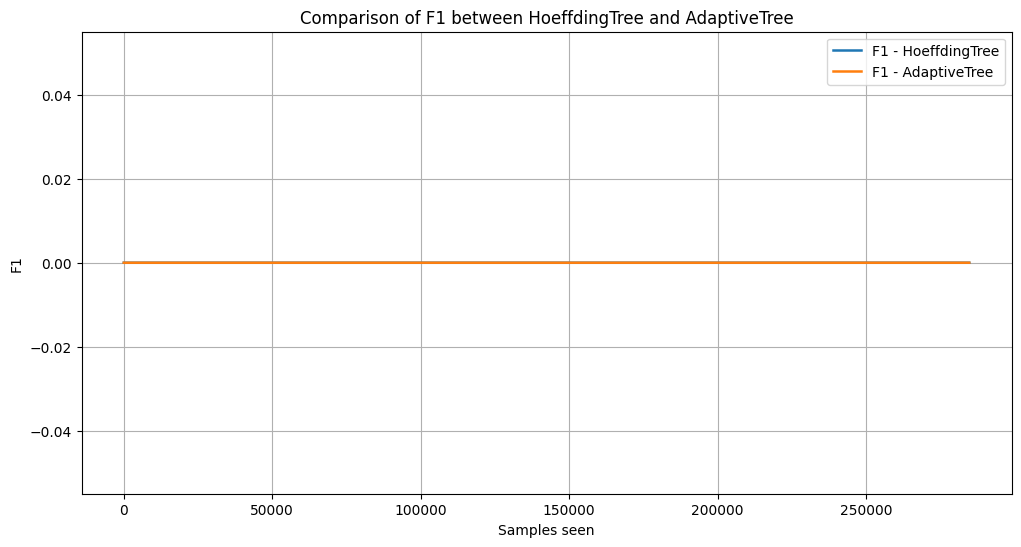

In [15]:
metrics_names = list(results_tree_h.keys())

for metric_name in metrics_names:
    plt.figure(figsize=(12, 6))

    # Plot pour Hoeffding Tree classique
    plt.plot(results_tree_h[metric_name],

             label=f"{metric_name} - HoeffdingTree",
             linewidth=1.8)

    # Plot pour Hoeffding Adaptive Tree
    plt.plot(results_tree_adaptive[metric_name],
            label=f"{metric_name} - AdaptiveTree",
           linewidth=1.8)

    plt.xlabel("Samples seen")
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} between HoeffdingTree and AdaptiveTree")
    plt.grid(True)
    plt.legend()
    plt.show()

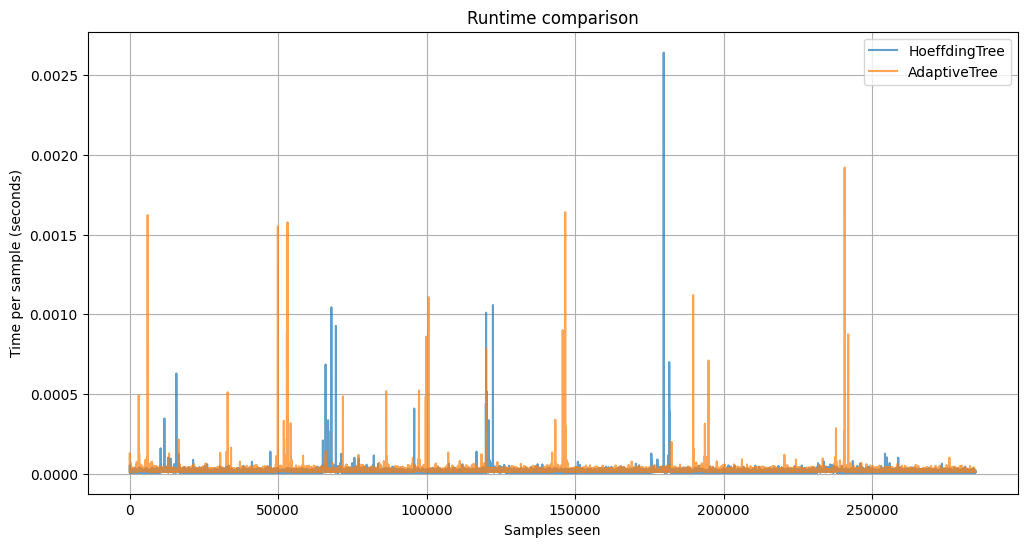

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(runtimes_tree_h, label="HoeffdingTree", alpha=0.7)
plt.plot(runtimes_tree_adaptive, label="AdaptiveTree", alpha=0.7)
plt.xlabel("Samples seen")
plt.ylabel("Time per sample (seconds)")
plt.title("Runtime comparison")
plt.grid(True)
plt.legend()
plt.show()

##**Etude 2**

In [17]:
dataset = datasets.HTTP()
dataset

HTTP dataset of the KDD 1999 cup.

The goal is to predict whether or not an HTTP connection is anomalous or not. The dataset only
contains 2,211 (0.4%) positive labels.

      Name  HTTP                                                      
      Task  Binary classification                                     
   Samples  567,498                                                   
  Features  3                                                         
    Sparse  False                                                     
      Path  /root/river_data/HTTP/kdd99_http.csv                      
       URL  https://maxhalford.github.io/files/datasets/kdd99_http.zip
      Size  30.9 MiB                                                  
Downloaded  False                                                     

In [18]:
x, y = next(iter(dataset))
x

Uncompressing into /root/river_data/HTTP


{'duration': -2.302585092994045,
 'src_bytes': 5.371103036273683,
 'dst_bytes': 10.716107451545245}

In [19]:
y

0

##**Logistic** **Regression**

In [20]:
from river import compose

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(optimizer=optim.SGD(0.1)))
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  LogisticRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.1
      )
    )
    loss=Log (
      weight_pos=1.
      weight_neg=1.
    )
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
)

In [21]:
metrics_list = [metrics.ROCAUC(), metrics.Precision(), metrics.Recall(), metrics.F1()]

In [22]:
from river import metrics

def evaluate_river_model(model):
  metrics_list = [metrics.ROCAUC(), metrics.Precision(), metrics.Recall(), metrics.F1()]
  print("Initial metrics for the model")
  for i in range(len(metrics_list)):
    metric_log=metrics_list[i]
    print(metrics_list[i])
  results = {type(m).__name__: [] for m in metrics_list}
  runtimes = []

  for x, y in dataset:
    tic=time.time()
    y_pred = model.predict_proba_one(x)
    runtimes.append(time.time() - tic)

    for metric in metrics_list:
        if isinstance(metric, metrics.ROCAUC) or isinstance(metric, metrics.LogLoss):
            metric.update(y, y_pred)
        elif len(y_pred):
            y_pred_proba=y_pred.get(1,0)
            metric.update(y, int( y_pred_proba> 0.5) )
        results[type(metric).__name__].append(metric.get())

    model.learn_one(x, y)
  print("Final metrics for the model")
  for i in range(len(metrics_list)):
    metric_log=metrics_list[i]
    print(metrics_list[i])
  return results, runtimes

In [23]:
results,runtimes = evaluate_river_model(model)

Initial metrics for the model
ROCAUC: -0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
Final metrics for the model
ROCAUC: 99.77%
Precision: 98.08%
Recall: 99.50%
F1: 98.79%


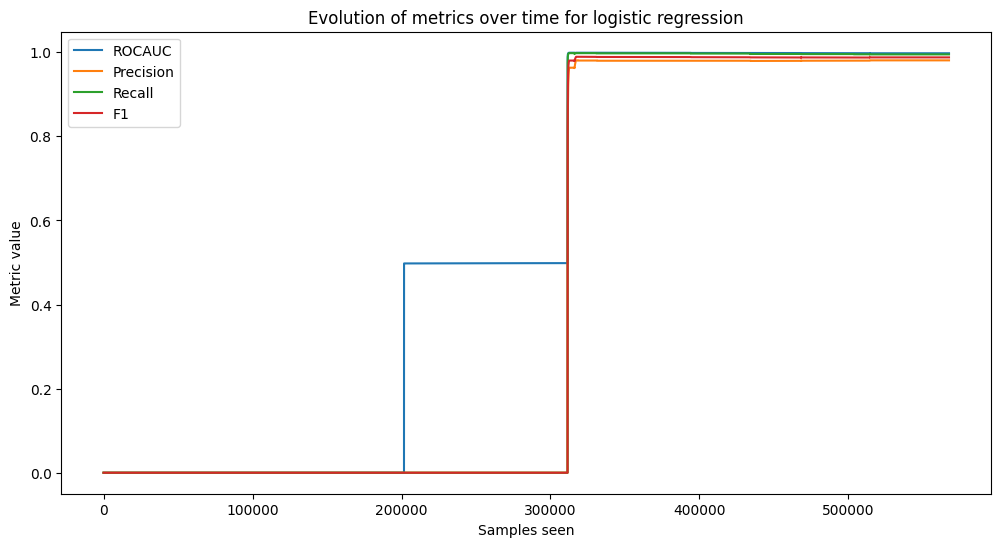

Average time per sample: 8.151313335642314e-06


In [24]:
plt.figure(figsize=(12, 6))
for metric_name, values in results.items():
    plt.plot(values, label=metric_name)
plt.xlabel("Samples seen")
plt.ylabel("Metric value")
plt.title("Evolution of metrics over time for logistic regression")
plt.legend()
plt.show()

# Temps moyen par échantillon
print("Average time per sample:", sum(runtimes)/len(runtimes))

## **Naive-Bayes Classifier**

In [25]:
from river import naive_bayes

In [26]:
model=naive_bayes.GaussianNB()

In [27]:
results, runtimes = evaluate_river_model(model)

Initial metrics for the model
ROCAUC: -0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
Final metrics for the model
ROCAUC: 99.80%
Precision: 99.14%
Recall: 99.59%
F1: 99.37%


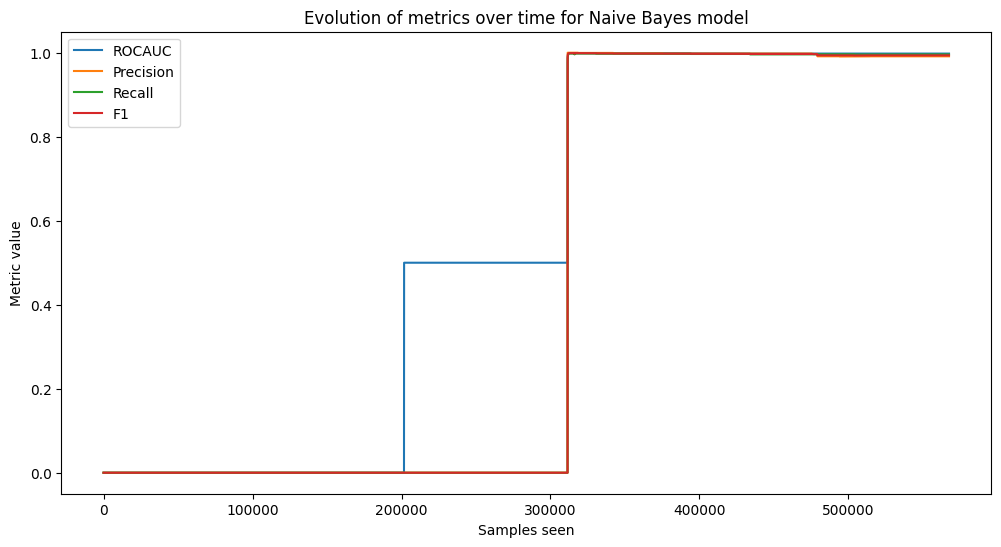

Average time per sample: 0.00016844225643849474


In [28]:
plt.figure(figsize=(12, 6))
for metric_name, values in results.items():
    plt.plot(values, label=metric_name)
plt.xlabel("Samples seen")
plt.ylabel("Metric value")
plt.title("Evolution of metrics over time for Naive Bayes model")
plt.legend()
plt.show()

# Temps moyen par échantillon
print("Average time per sample:", sum(runtimes)/len(runtimes))

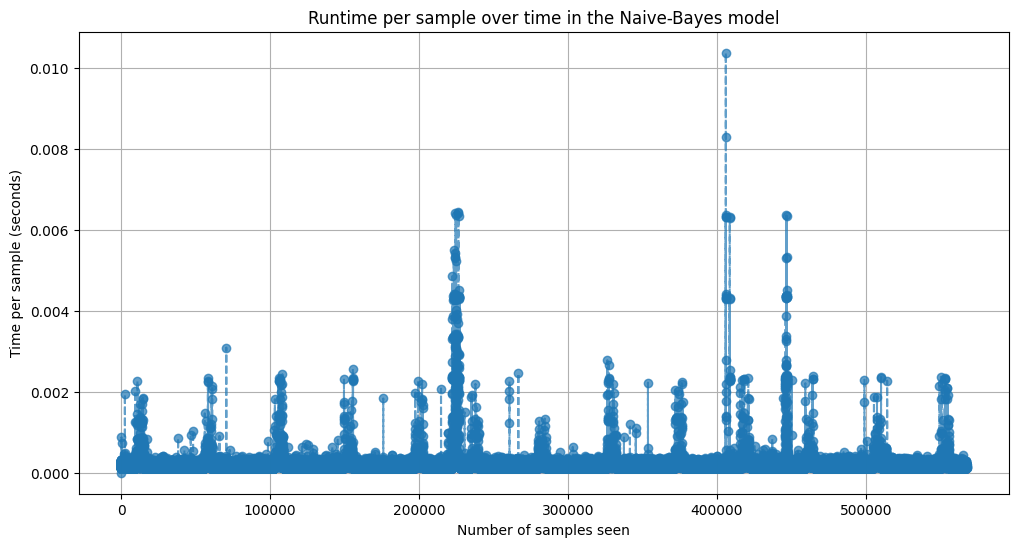

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(runtimes)+1), runtimes, marker='o', linestyle='dashed', alpha=0.7)
plt.xlabel("Number of samples seen")
plt.ylabel("Time per sample (seconds)")
plt.title("Runtime per sample over time in the Naive-Bayes model")
plt.grid(True)
plt.show()

## **Hoeffding Tree Classifier**

In [30]:
tree_h = tree.HoeffdingTreeClassifier(
    grace_period=50,          # 50 est trop petit, risque de splits prématurés
     # Multi-way splits (plus flexible)
    merit_preprune=True,       # Évite l'overfitting
)

In [31]:
results_tree_h, runtimes_tree_h = evaluate_river_model(tree_h)

Initial metrics for the model
ROCAUC: -0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
Final metrics for the model
ROCAUC: 50.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


## **Hoeffding Adaptive Tree Classifier**

In [32]:
tree_adaptive = tree.HoeffdingAdaptiveTreeClassifier(
    grace_period=50,
    max_depth=None,
    leaf_prediction='nba',
    nb_threshold=0,
    delta=1e-07,
    drift_window_threshold=300,
    bootstrap_sampling=True,
    merit_preprune=True,
    seed=42
)

In [33]:
results_tree_adaptive, runtimes_tree_adaptive= evaluate_river_model(tree_adaptive)

Initial metrics for the model
ROCAUC: -0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
Final metrics for the model
ROCAUC: 50.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


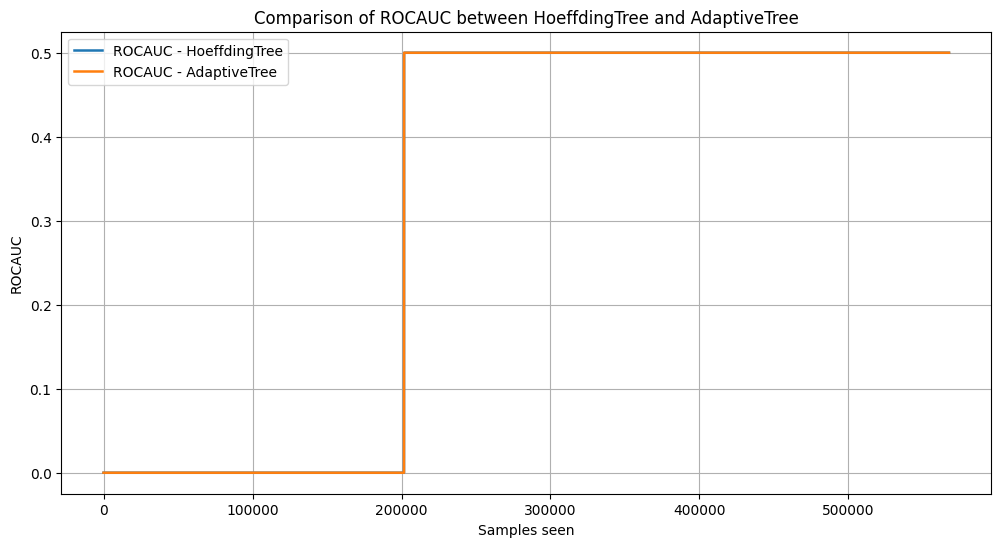

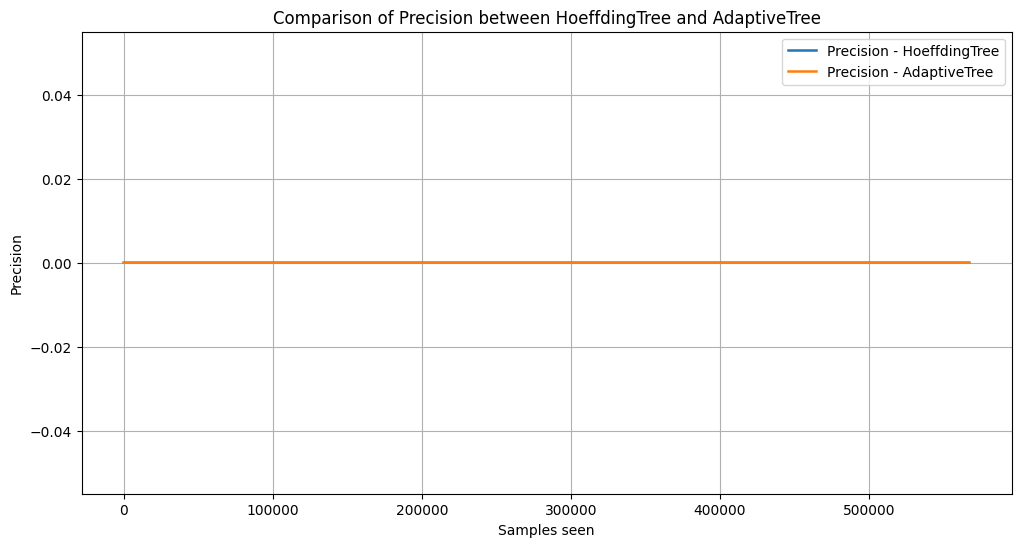

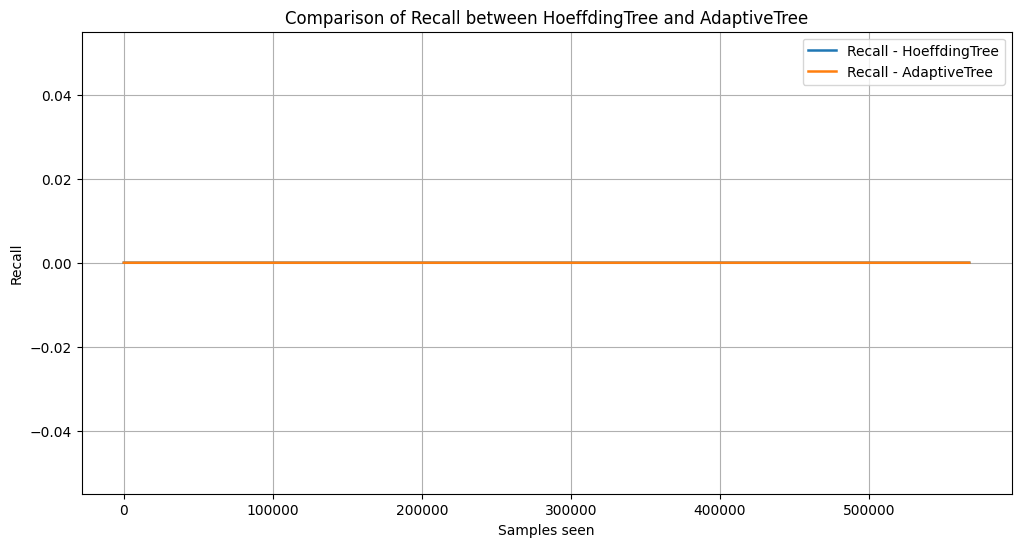

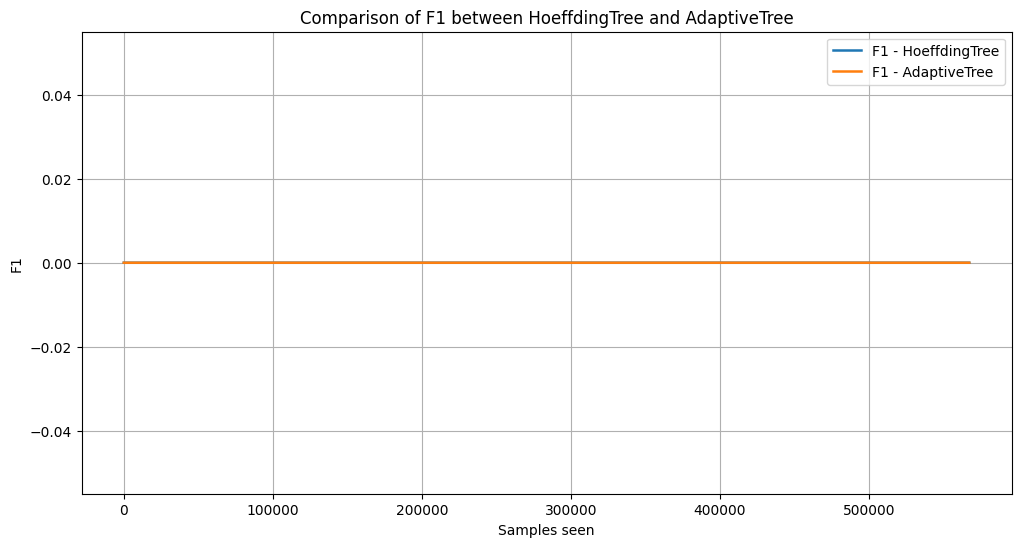

In [34]:
metrics_names = list(results_tree_h.keys())

for metric_name in metrics_names:
    plt.figure(figsize=(12, 6))

    # Plot pour Hoeffding Tree classique
    plt.plot(results_tree_h[metric_name],

             label=f"{metric_name} - HoeffdingTree",
             linewidth=1.8)

    # Plot pour Hoeffding Adaptive Tree
    plt.plot(results_tree_adaptive[metric_name],
            label=f"{metric_name} - AdaptiveTree",
           linewidth=1.8)

    plt.xlabel("Samples seen")
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} between HoeffdingTree and AdaptiveTree")
    plt.grid(True)
    plt.legend()
    plt.show()

## **Half Space Trees**

Initial metrics for the model
ROCAUC: -0.00%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
Final metrics for the model
ROCAUC: 50.69%
Precision: 1.21%
Recall: 2.04%
F1: 1.52%


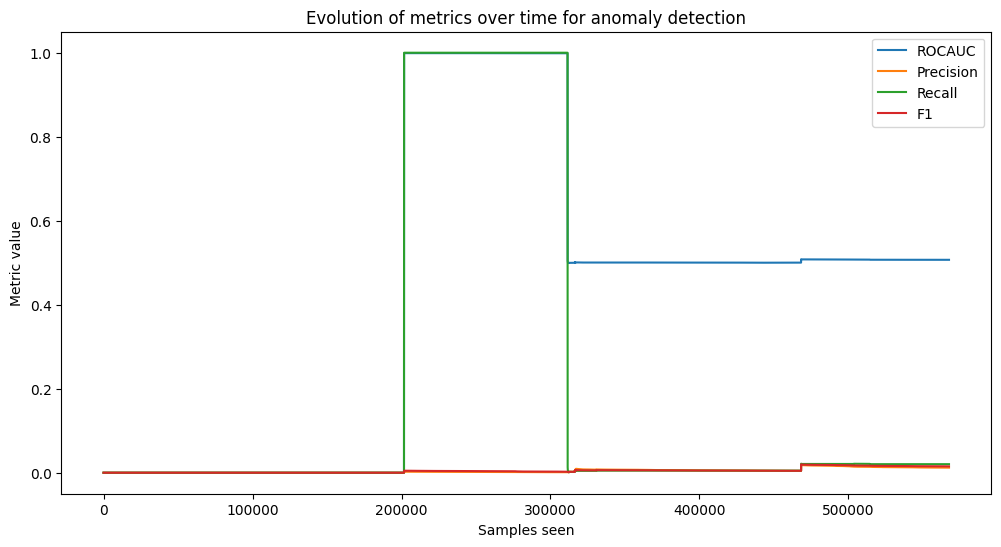

In [35]:
from river import anomaly
from river import metrics

model= anomaly.HalfSpaceTrees(n_trees=50,height=10, window_size=500)
threshold=0.5

metrics_list=[metrics.ROCAUC(), metrics.Precision(), metrics.Recall(), metrics.F1()]
results = {type(m).__name__: [] for m in metrics_list}
runtimes = []

print("Initial metrics for the model")
for i in range(len(metrics_list)):
  metric_log=metrics_list[i]
  print(metrics_list[i])

for x, y in dataset:
  score= model.score_one(x)

  tic= time.time()
  y_pred= int(score> threshold)
  runtimes.append(time.time() - tic)

  for metric in metrics_list:
    metric.update(y, y_pred)
    results[type(metric).__name__].append(metric.get())

  model.learn_one(x)

print("Final metrics for the model")
for i in range(len(metrics_list)):
  metric_log=metrics_list[i]
  print(metrics_list[i])

plt.figure(figsize=(12, 6))
for metric_name, values in results.items():
    plt.plot(values, label=metric_name)

plt.xlabel("Samples seen")
plt.ylabel("Metric value")
plt.title("Evolution of metrics over time for anomaly detection")
plt.legend()
plt.show()

##Capymoa

In [36]:
!pip install capymoa

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d6f0e403663b8ba1fa449f1890443c10f0e317ed5f466d0d81bec0f0721a04bc
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0


In [37]:
from capymoa.datasets import RBFm_100k
from capymoa.evaluation import ClassificationEvaluator
from capymoa.classifier import OnlineBagging

stream =RBFm_100k()
ob_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=5)
ob_evaluator = ClassificationEvaluator(schema=stream.get_schema())

for instance in stream:
    prediction = ob_learner.predict(instance)
    ob_learner.train(instance)
    ob_evaluator.update(instance.y_index, prediction)

print(ob_evaluator.accuracy())

RBFm_100k.arff: 8.62MB [00:01, 6.93MB/s]                            


60.357000000000006


In [38]:
stream

HAT accuracy = 60.356
HT accuracy = 57.928000000000004
ARF accuracy = 83.499
NB accuracy = 36.785000000000004


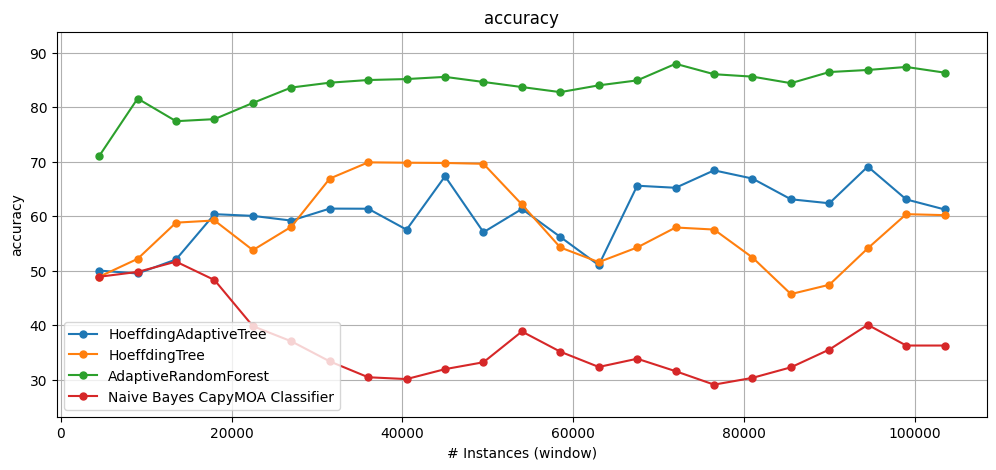

In [39]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.base import MOAClassifier
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingTree
from moa.classifiers.trees import HoeffdingAdaptiveTree
from capymoa.classifier import HoeffdingTree
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.classifier import NaiveBayes

# Create the wrapper for HoeffdingAdaptiveTree (from MOA)
HAT = MOAClassifier(
    schema=stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50"
)
HT = HoeffdingTree(schema=stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForestClassifier(
    schema=stream.get_schema(), ensemble_size=10, number_of_jobs=4
)
nb=NaiveBayes(stream.get_schema())

results_HAT = prequential_evaluation(stream=stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=stream, learner=ARF, window_size=4500)
results_nb = prequential_evaluation(stream=stream, learner=nb, window_size=4500)

# Comparing models based on their cumulative accuracy
print(f"HAT accuracy = {results_HAT.cumulative.accuracy()}")
print(f"HT accuracy = {results_HT.cumulative.accuracy()}")
print(f"ARF accuracy = {results_ARF.cumulative.accuracy()}")
print(f"NB accuracy = {results_nb.cumulative.accuracy()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric.
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    results_nb,
    metric="accuracy",
    xlabel="# Instances (window)",
)

In [40]:
print(f'HAT kappa = {results_HAT.cumulative.kappa()}')
print(f'HT kappa = {results_HT.cumulative.kappa()}')
print(f'ARF kappa = {results_ARF.cumulative.kappa()}')
print(f'NB kappa = {results_nb.cumulative.kappa()}')

HAT kappa = 48.2592335572191
HT kappa = 45.25317535223247
ARF kappa = 78.5136765532225
NB kappa = 15.492229964399343


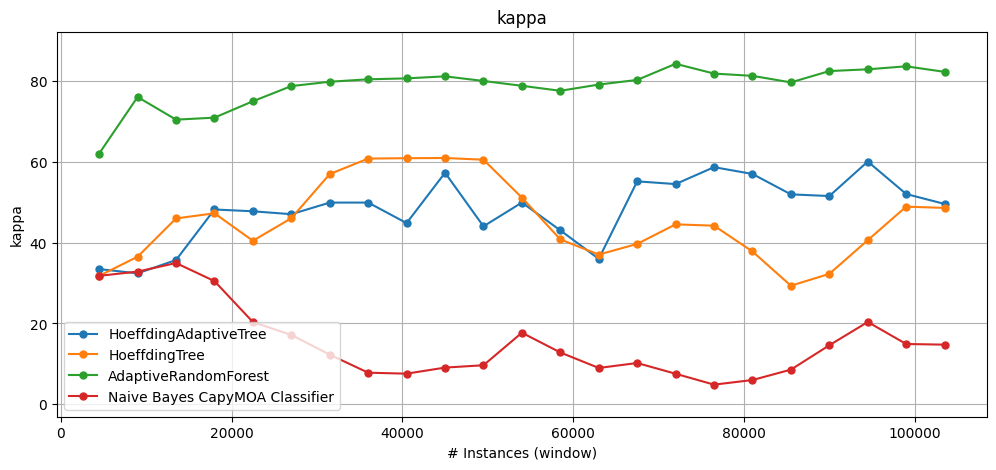

In [41]:
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    results_nb,
    metric="kappa",
    xlabel="# Instances (window)",
)

electricity.arff: 704kB [00:01, 718kB/s]                    


HAT accuracy = 84.68617584745762
HT accuracy = 81.6604872881356
ARF accuracy = 89.32953742937853
NB accuracy = 73.36246468926554


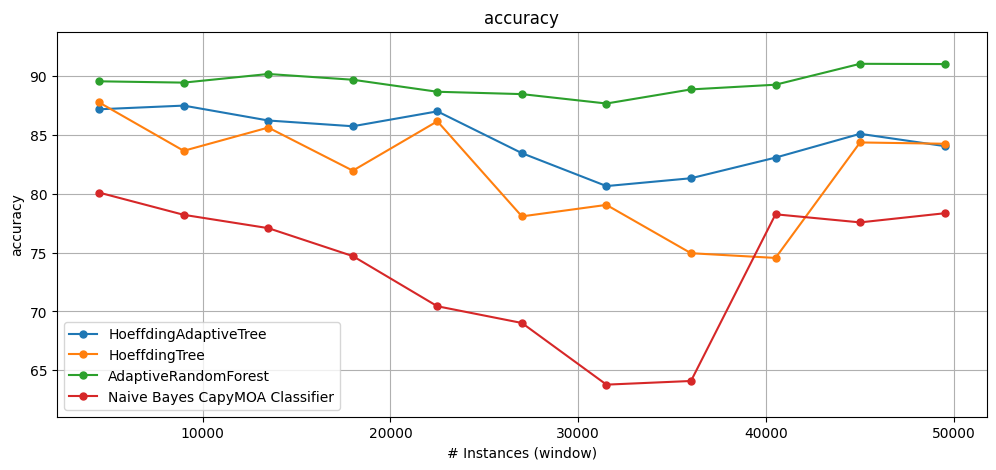

In [42]:
from capymoa.datasets import Electricity
stream=Electricity()
HAT = MOAClassifier(
    schema=stream.get_schema(), moa_learner=HoeffdingAdaptiveTree, CLI="-g 50"
)
HT = HoeffdingTree(schema=stream.get_schema(), grace_period=50)
ARF = AdaptiveRandomForestClassifier(
    schema=stream.get_schema(), ensemble_size=10, number_of_jobs=4
)
nb=NaiveBayes(stream.get_schema())

results_HAT = prequential_evaluation(stream=stream, learner=HAT, window_size=4500)
results_HT = prequential_evaluation(stream=stream, learner=HT, window_size=4500)
results_ARF = prequential_evaluation(stream=stream, learner=ARF, window_size=4500)
results_nb = prequential_evaluation(stream=stream, learner=nb, window_size=4500)

# Comparing models based on their cumulative accuracy
print(f"HAT accuracy = {results_HAT.cumulative.accuracy()}")
print(f"HT accuracy = {results_HT.cumulative.accuracy()}")
print(f"ARF accuracy = {results_ARF.cumulative.accuracy()}")
print(f"NB accuracy = {results_nb.cumulative.accuracy()}")

# Plotting the results. Note that we ovewrote the ylabel, but that doesn't change the metric.
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    results_nb,
    metric="accuracy",
    xlabel="# Instances (window)",
)

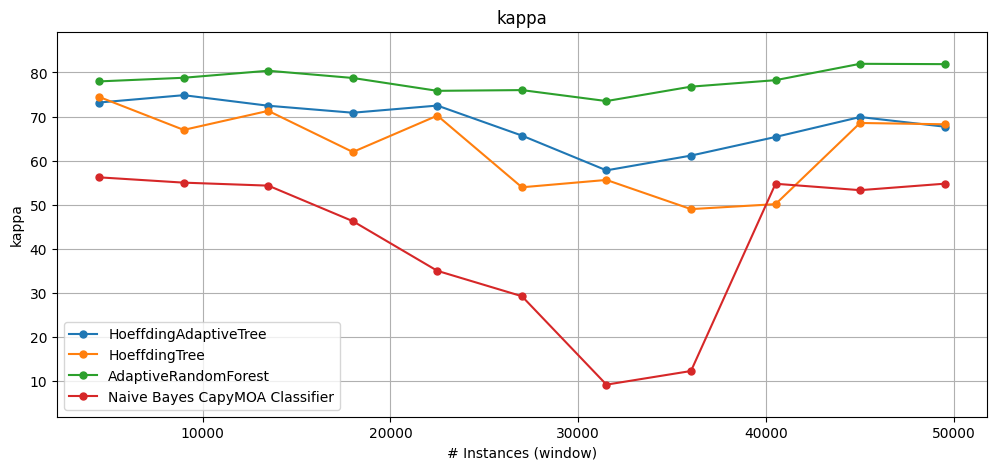

In [43]:
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    results_nb,
    metric="kappa",
    xlabel="# Instances (window)",
)

In [44]:
plot_windowed_results(
    results_HAT,
    results_HT,
    results_ARF,
    results_nb,
    metric="",
    xlabel="# Instances (window)",
)

Column '' not found in metrics DataFrame for HoeffdingAdaptiveTree. Skipping.
Column '' not found in metrics DataFrame for HoeffdingTree. Skipping.
Column '' not found in metrics DataFrame for AdaptiveRandomForest. Skipping.
Column '' not found in metrics DataFrame for Naive Bayes CapyMOA Classifier. Skipping.
No valid DataFrames to plot.
